In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# universal color map for Yeo's networks

In [3]:
import numpy as np
import seaborn

In [37]:
# load cmap17 values from txt file
def yeo_cmap(as_palette=False, networks=7):
    """load cmap7 or cmap17 from txt file in directory"""
    assert networks in (7, 17)
    cmap = {}
    with open('data/' + f'_cmap{networks}.txt', 'r') as f:
        for line in f.readlines():
            k, r, g, b = line.split()
            cmap[k] = (int(r), int(g), int(b))
    cmap = {k: np.array(v) / 255 for k, v in cmap.items()}

    if as_palette:  return seaborn.color_palette(cmap.values())
    else:   return cmap

In [38]:
seaborn.set(style='white', context='notebook',rc={'figure.figsize': (7, 5)})

In [39]:
cmap8 = yeo_cmap(as_palette=True)
cmap8

[(0.4666666666666667, 0.0784313725490196, 0.5490196078431373),
 (0.27450980392156865, 0.49411764705882355, 0.6862745098039216),
 (0.0, 0.4588235294117647, 0.027450980392156862),
 (0.7647058823529411, 0.23137254901960785, 1.0),
 (0.8588235294117647, 0.9764705882352941, 0.6470588235294118),
 (0.9019607843137255, 0.5843137254901961, 0.12941176470588237),
 (0.803921568627451, 0.2549019607843137, 0.3137254901960784),
 (0.0, 0.0, 0.0)]

# gradients
large-scale manifold

In [7]:
import pandas as pd

In [8]:
approach = 'pca'

In [9]:
RAND = 0    # random state

if you don't apply cosine kernel while making affinity mat, you get way skewed gradient values.

In [10]:
# this is computed based on `baseline`
ref_cmat = pd.read_csv('data/cmat/ref_mean.csv').to_numpy()

In [11]:
from brainspace.gradient import GradientMaps

In [12]:
import seaborn
from matplotlib import pyplot as plt

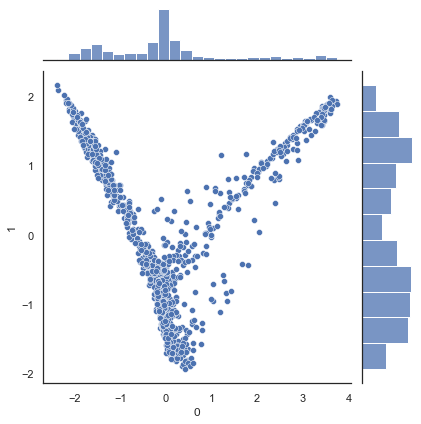

In [13]:
gref = GradientMaps(random_state=RAND, approach=approach, kernel='cosine')
# kernel needed for centered mats
gref.fit(ref_cmat)
seaborn.jointplot(data=pd.DataFrame(gref.gradients_), x=0, y=1)
plt.show()

In [14]:
def cmat_cnt(subject, epoch): return pd.read_csv('data/cmat/cnt/cnt_'+str(subject)+'_'+epoch+'.csv').to_numpy()

In [15]:
EPOCHS = ['baseline', 'early', 'late']
EPOCH_REF = 'baseline'

In [16]:
subjects = pd.read_csv('data/subjects.csv')

In [17]:
# g = GradientMaps(random_state=RAND, approach=approach, alignment='procrustes', kernel='cosine')
# g.fit([cmat_cnt(s, e) for e in EPOCHS for s in subjects.int_id], reference=gref.gradients_)
# np.stack(g.aligned_).shape

In [18]:
# plt.hist(g.aligned_[0][:, 0], bins=50) # grad1
# plt.show()
# plt.hist(g.aligned_[0][:, 1], bins=50) # grad2
# plt.show()

# make dataframe

In [19]:
# important: this is how the g.aligned_ list is organized
S = [1,2]
l = [(s, e) for e in EPOCHS for s in S]
print(l)
l[EPOCHS.index('late') * len(S) + S.index(2)]   # selects element for s=2, e='late'

[(1, 'baseline'), (2, 'baseline'), (1, 'early'), (2, 'early'), (1, 'late'), (2, 'late')]


(2, 'late')

In [20]:
r = pd.read_csv('data/regions_sorted.csv')

In [21]:
S = subjects.int_id.to_list()

# df = pd.concat([pd.DataFrame({'subject': s, 'epoch': e,
#                               'region': r['region'], '7net': r['7net'], '17net': r['17net'],
#                               'g1': g.aligned_[EPOCHS.index(e) * len(S) + S.index(s)][:, 0],
#                               'g2': g.aligned_[EPOCHS.index(e) * len(S) + S.index(s)][:, 1],
#                               'g3': g.aligned_[EPOCHS.index(e) * len(S) + S.index(s)][:, 2], })
#                 for e in EPOCHS for s in S], axis=0).reset_index(drop=True)

In [22]:
# df

In [23]:
# make use of palette

In [24]:
names7nets = r['7net'].unique().tolist()

In [25]:
# seaborn.displot(df.sample(10_000), x='g1', hue='7net', kind='kde', fill=True,
#                 palette=cmap8,
#                 hue_order=names7nets,
#                 )
# plt.show()
# # plt.savefig("sample10_000.svg", format="svg")

In [26]:
# this is the 3d plot. it would mess up the notebook if run
# fig = px.scatter_3d(df.sample(1000), x='g1', y='g2', z='g3', color='label', opacity=.4)
# fig.update_traces(marker_size=3)
# fig.show()

## Eccentricity

the Euclidean distance from the manifold center. 3D space.
$Ecc = \sqrt{\sum_{\substack{i=1}}^3 G_i^2}$

In [27]:
# df['ecc'] = df.apply(lambda r: np.sqrt(np.sum(g**2 for g in r[-3:])), axis=1)

In [28]:
# df.to_csv('data/gradients.csv', index=False)

In [29]:
df = pd.read_csv('data/gradients.csv')

In [35]:
df.head()

,subject,epoch,region,7net,17net,g1,g2,g3,g4,ecc
0,1,baseline,7Networks_LH_Vis_1,Vis,DorsAttnA,0.516958,-0.186538,1.501042,-0.668984,1.732833
1,1,baseline,7Networks_LH_Vis_2,Vis,VisCent,0.636391,1.407541,0.977047,-0.758676,1.978984
2,1,baseline,7Networks_LH_Vis_3,Vis,DorsAttnA,0.396966,0.630318,1.806822,0.007569,1.954366
3,1,baseline,7Networks_LH_Vis_4,Vis,VisCent,2.380421,2.049884,0.085447,-0.858037,3.257601
4,1,baseline,7Networks_LH_Vis_5,Vis,DefaultC,0.408135,0.698659,0.977117,0.278002,1.298746


average

In [36]:
df_mean = df.groupby(['region', 'epoch', '7net', '17net']).agg('mean').drop('subject', axis=1).reset_index()
df_mean.head()

,region,epoch,7net,17net,g1,g2,g3,g4,ecc
0,7Networks_LH_Cont_Cing_1,baseline,Cont,SalVentAttnB,-1.568082,-0.292681,-0.214813,-0.957925,2.360363
1,7Networks_LH_Cont_Cing_1,early,Cont,SalVentAttnB,-1.635978,0.037227,-0.567208,-0.542964,2.458661
2,7Networks_LH_Cont_Cing_1,late,Cont,SalVentAttnB,-1.657511,0.038653,-0.614793,-0.953411,2.567954
3,7Networks_LH_Cont_Cing_2,baseline,Cont,ContC,0.483634,-1.805169,-0.963203,1.607929,2.988855
4,7Networks_LH_Cont_Cing_2,early,Cont,ContC,0.398380,-1.651304,-1.331622,1.320727,2.797557


In [32]:
# caution: `groupby` changes regions' ordering. This doesn't start with `LH_Vis`
df_mean = df_mean.set_index('region').loc[pd.Series(r['region'])].reset_index()
df_mean.head()

,region,epoch,7net,17net,g1,g2,g3,g4,ecc
0,7Networks_LH_Vis_1,baseline,Vis,DorsAttnA,0.714618,0.179757,0.540071,-0.233079,1.968233
1,7Networks_LH_Vis_1,early,Vis,DorsAttnA,0.682796,-0.116861,0.256490,-0.536388,1.841965
2,7Networks_LH_Vis_1,late,Vis,DorsAttnA,0.278858,-0.245021,-0.090645,-0.324249,1.682773
3,7Networks_LH_Vis_2,baseline,Vis,VisCent,1.241687,1.268604,0.866375,-0.177822,2.693591
4,7Networks_LH_Vis_2,early,Vis,VisCent,1.140651,1.299236,0.771234,-0.147166,2.494169


In [33]:
g1range = (-5,7)
g2range = (-5,4)
g3range = (-4.5,4)

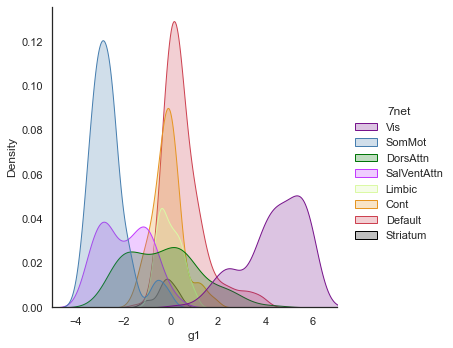

In [40]:
seaborn.displot(df_mean[df_mean.epoch=='late'], x='g1', hue='7net', kind='kde', fill=True,
                palette=cmap8,hue_order=names7nets,
                )
plt.xlim(*g1range)
plt.savefig("g1 late.svg", format="svg")

# brain plot

## cortex

In [41]:
import nibabel
from brainspace.datasets import load_conte69
from brainspace.utils.parcellation import map_to_labels
from surfplot import Plot

In [42]:
fname = '/Users/qasem/PycharmProjects/gradients-rl-task/data/Schaefer2018_1000Parcels_7Networks_order.dlabel.nii'
l_hemi, r_hemi = load_conte69()
vertices = nibabel.load(fname).get_fdata()[0]

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


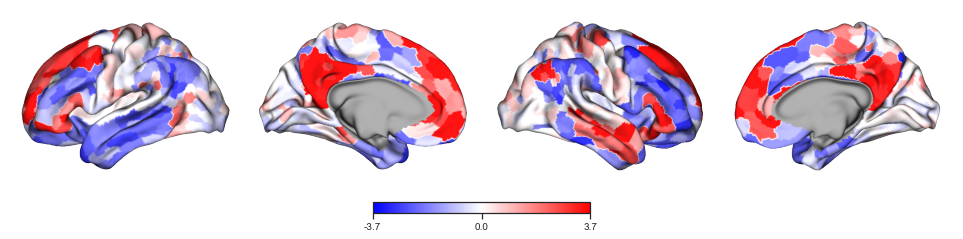

In [43]:
data = df_mean[df_mean.epoch=='baseline'].reset_index()['g1']
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='row', size=(1600, 300))
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-3.7, 3.7))
figure = p.build()
figure.savefig('test.png', dpi=300)

<AxesSubplot:>

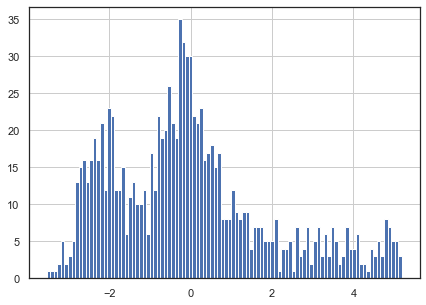

In [44]:
df_mean.loc[df_mean.epoch=='baseline', 'g1'].hist(bins=100)

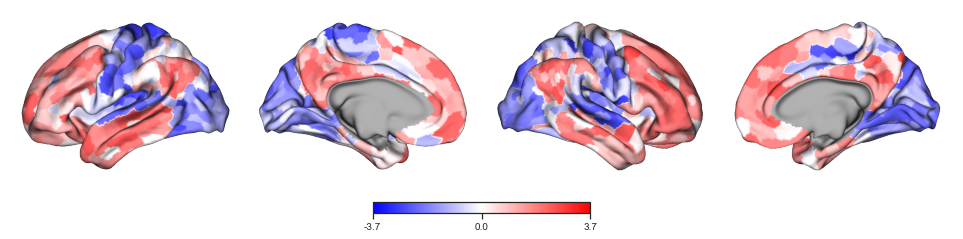

In [45]:
data = df_mean[df_mean.epoch=='baseline'].reset_index()['g2']
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='row', size=(1600, 300))
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-3.7, 3.7))
figure = p.build()
figure.savefig('test.png', dpi=300)

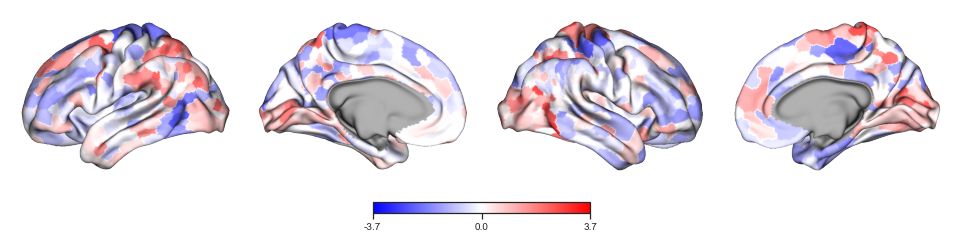

In [46]:
data = df_mean[df_mean.epoch=='baseline'].reset_index()['g3']
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='row', size=(1600, 300))
p.add_layer(data, cbar=True, cmap='bwr', color_range=(-3.7, 3.7))
figure = p.build()
figure.savefig('test.png', dpi=300)

### eccentricity

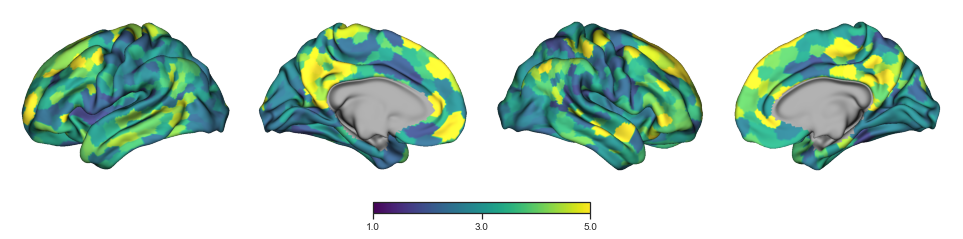

In [47]:
data = df_mean[df_mean.epoch=='baseline'].reset_index()['ecc']
data = map_to_labels(data, vertices, mask=(vertices != 0))
p = Plot(surf_lh=l_hemi, surf_rh=r_hemi, layout='row', size=(1600, 300))
p.add_layer(data, cbar=True,
            cmap='viridis',color_range=(1,5))
figure = p.build()
figure.savefig('test.png', dpi=300)

## subcortex
distribution of gradient values in Striatum

![ecc striatum](data/sample-subcortex.png)

PC 1

<AxesSubplot:>

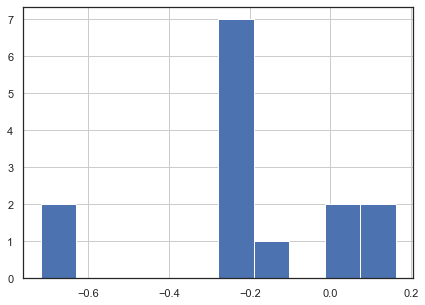

In [48]:
df_mean.set_index(['epoch', 'region']).loc['baseline'][-14:]['g1'].hist()

PC 2

<AxesSubplot:>

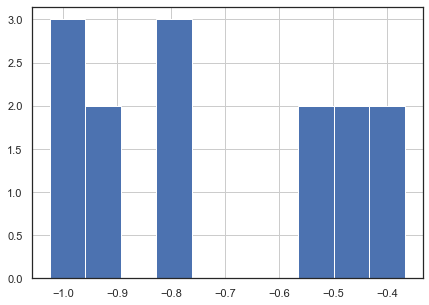

In [49]:
df_mean.set_index(['epoch', 'region']).loc['baseline'][-14:]['g2'].hist()

PC 3

<AxesSubplot:>

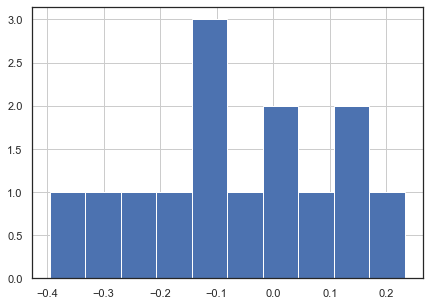

In [50]:
df_mean.set_index(['epoch', 'region']).loc['baseline'][-14:]['g3'].hist()

### setup plotting

In [51]:
subcortex_order = ['Left Accumbens',
                     'Left Amygdala',
                     'Left Caudate',
                     'Left Hippocampus',
                     'Left Pallidum',
                     'Left Putamen',
                     'Left Thalamus',
                     # 'Left Ventricles',
                     'Right Accumbens',
                     'Right Amygdala',
                     'Right Caudate',
                     'Right Hippocampus',
                     'Right Pallidum',
                     'Right Putamen',
                     'Right Thalamus',
                     # 'Right Ventricles',
                   ]

# to reorder data regarding function input
# array_name = data.loc[subcortex_order]
# two values removed, ventricles must set False

In [52]:
data = df_mean.set_index(['epoch', 'region']).loc['baseline'].loc[subcortex_order]['g1']

In [53]:
data

region
Left Accumbens       0.004222
Left Amygdala       -0.266358
Left Caudate        -0.197427
Left Hippocampus     0.125778
Left Pallidum       -0.109176
Left Putamen        -0.695973
Left Thalamus       -0.203063
Right Accumbens      0.020292
Right Amygdala      -0.250497
Right Caudate       -0.201204
Right Hippocampus    0.161772
Right Pallidum      -0.268704
Right Putamen       -0.718762
Right Thalamus      -0.216845
Name: g1, dtype: float64

In [54]:
from enigmatoolbox.plotting import plot_subcortical

plot_subcortical(data, ventricles=False,
                 size=(800, 400), cmap='bwr', color_bar=True, color_range=(-1, 1),
                 screenshot=True, filename='g1.png'
                 )

'/Users/qasem/PycharmProjects/large-manifold-nbs/g1.png'

In [55]:
data = df_mean.set_index(['epoch', 'region']).loc['baseline'].loc[subcortex_order]['g2']

plot_subcortical(data, ventricles=False,
                 size=(800, 400), cmap='bwr', color_bar=True, color_range=(-1, 1),
                 screenshot=True, filename='g2.png'
                 )

'/Users/qasem/PycharmProjects/large-manifold-nbs/g2.png'

In [56]:
data = df_mean.set_index(['epoch', 'region']).loc['baseline'].loc[subcortex_order]['g3']

plot_subcortical(data, ventricles=False,
                 size=(800, 400), cmap='bwr', color_bar=True, color_range=(-1, 1),
                 screenshot=True, filename='g3.png'
                 )

'/Users/qasem/PycharmProjects/large-manifold-nbs/g3.png'

### eccentricity

In [57]:
ecc_color_range = (1,6)    # (1, 1.5)

In [58]:
data = df_mean.set_index(['epoch', 'region']).loc['baseline'].loc[subcortex_order]['ecc']

plot_subcortical(data, ventricles=False,
                 size=(800, 400), cmap='viridis', color_bar=True, color_range=ecc_color_range,
                 screenshot=True, filename='ecc.png'
                 )

'/Users/qasem/PycharmProjects/large-manifold-nbs/ecc.png'

# appendix scatter plots

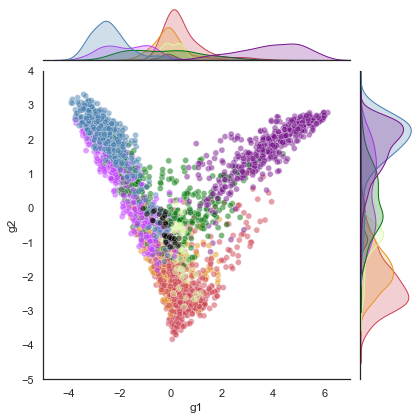

In [59]:
seaborn.jointplot(data=df_mean,
                  x='g1', y='g2',
                  xlim=g1range, ylim=g2range,
                  hue='7net',
                  palette=cmap8,hue_order=names7nets,
                  legend=False,
                       alpha=.5,
                  )
plt.savefig("g1g2.svg", format="svg")

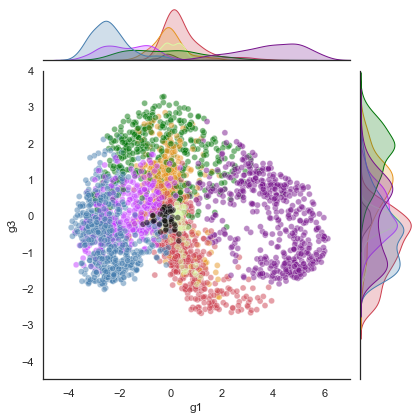

In [60]:
seaborn.jointplot(data=df_mean,
                  x='g1', y='g3',
                  xlim=g1range, ylim=g3range,
                  hue='7net',
                  palette=cmap8,hue_order=names7nets,
                  legend=False,
                       alpha=.5,
                  )
plt.savefig("g1g3.svg", format="svg")

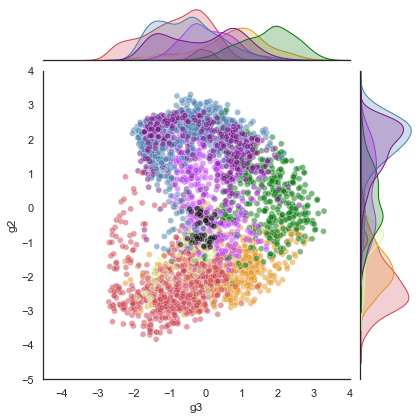

In [61]:
seaborn.jointplot(data=df_mean,
                  x='g3', y='g2',
                  xlim=g3range,
                  ylim=g2range,
                  hue='7net',
                  palette=cmap8,hue_order=names7nets,
                  legend=False, alpha=.5,
                  )
plt.savefig("g3g2.svg", format="svg")

# swarm plot eccentricity of one region for all subjects

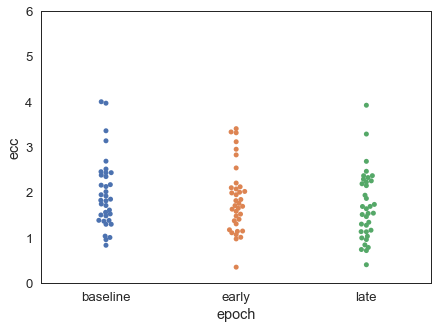

In [62]:
seaborn.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
seaborn.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
# set y axis range
seaborn.swarmplot(data=df[df.region=='7Networks_LH_Vis_1'], x='epoch', y='ecc')
plt.ylim(0, 6)
plt.show()

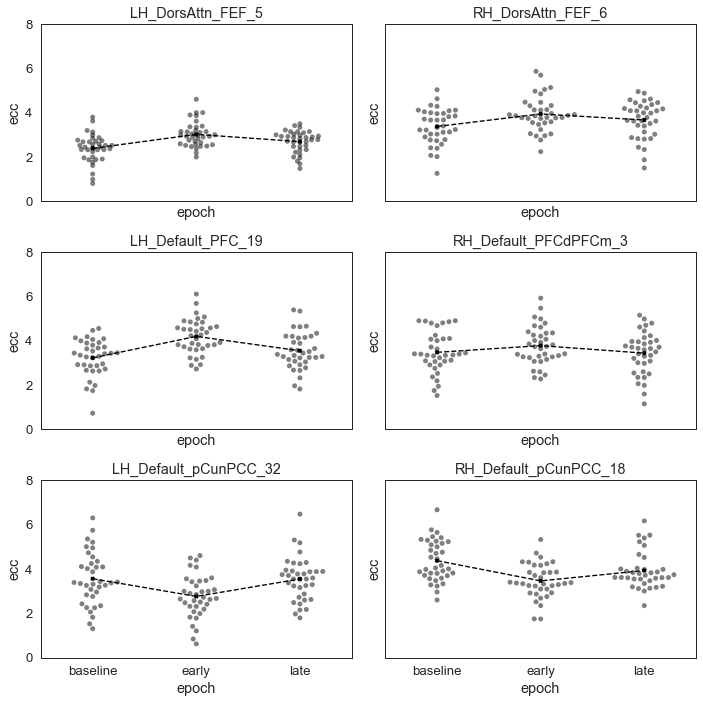

In [63]:
regions = ['LH_DorsAttn_FEF_5', 'RH_DorsAttn_FEF_6',            # FEF
           'LH_Default_PFC_19', 'RH_Default_PFCdPFCm_3',        # PFC
           'LH_Default_pCunPCC_32', 'RH_Default_pCunPCC_18',    # PCC
           ]

seaborn.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
seaborn.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})
fig, axes = plt.subplots(3, 2, figsize=(10, 10), sharex=True, sharey=True)

for i, region in enumerate(regions):
    seaborn.swarmplot(data=df[df.region=='7Networks_' + region], x='epoch', y='ecc',
                      ax=axes[i//2, i%2], color='black', alpha=.5)
    seaborn.pointplot(data=df[df.region=='7Networks_' + region], x='epoch', y='ecc', markers='X',
                      color='black', ci=None, join=True, scale=.3, linestyles='dashed', ax=axes[i//2, i%2])

    axes[i//2, i%2].set_ylim(0, 8)
    axes[i//2, i%2].set_title(region)

plt.tight_layout()
# plt.savefig('ecc-swarm-regions.svg', format='svg')
plt.show()

# variance cumulative explained

In [64]:
g = GradientMaps(random_state=RAND, approach=approach, alignment='procrustes', kernel='cosine')
g.fit([cmat_cnt(s, e) for e in EPOCHS for s in subjects.int_id], reference=gref.gradients_)
np.stack(g.aligned_).shape

(108, 1012, 10)

In [65]:
len(g.lambdas_)

108

In [66]:
e, s = 'baseline', 23
g.lambdas_[EPOCHS.index(e) * len(S) + S.index(s)]  # gives top 10 gradients

array([5.89733707, 3.42266247, 1.91803227, 1.78404697, 1.00650243,
       0.66744065, 0.59657604, 0.39942607, 0.34279046, 0.31993897])

In [67]:
df_var = pd.concat([pd.DataFrame({'subject': s, 'epoch': e,
                                  'eigenValue': g.lambdas_[EPOCHS.index(e) * len(S) + S.index(s)],
                                  'g': list(range(1,11)), })
                for e in EPOCHS for s in S], axis=0).reset_index(drop=True)
df_var.head()

,subject,epoch,eigenValue,g
0,1,baseline,4.685648,1
1,1,baseline,2.536675,2
2,1,baseline,1.978232,3
3,1,baseline,1.544357,4
4,1,baseline,0.941737,5


In [68]:
totalVariance = df_var.groupby(['subject', 'epoch'])['eigenValue'].sum().rename('totalVariance')

In [69]:
totalVariance

subject  epoch   
1        baseline    14.060079
         early       19.418897
         late        20.894894
2        baseline    15.882259
         early       18.448866
                       ...    
45       early       17.299838
         late        20.157760
46       baseline    23.361088
         early       17.786941
         late        22.618894
Name: totalVariance, Length: 108, dtype: float64

In [70]:
df_var.set_index(['subject', 'epoch'], inplace=True)

In [71]:
df_var = df_var.join(totalVariance)

In [72]:
df_var['varianceExplained'] = df_var['eigenValue'] / df_var['totalVariance']

In [73]:
df_var.reset_index(inplace=True)

In [76]:
df_var.head()

,subject,epoch,eigenValue,g,totalVariance,varianceExplained
0,1,baseline,4.685648,1,14.060079,0.333259
1,1,baseline,2.536675,2,14.060079,0.180417
2,1,baseline,1.978232,3,14.060079,0.140699
3,1,baseline,1.544357,4,14.060079,0.109840
4,1,baseline,0.941737,5,14.060079,0.066980


plot

In [79]:
seaborn.set(rc={'figure.figsize': (7, 8)})

In [80]:
# make percentage
df_var['varianceExplained'] = df_var['varianceExplained'] * 100

In [81]:
y = 'varianceExplained'

df_var_mean = df_var.groupby(['epoch', 'g'])[y].mean()#.unstack(0)

cumulative = True
if cumulative:  df_var_mean = df_var_mean.groupby(level=0).apply(
    lambda x: pd.Series(x.to_numpy().cumsum(), index=list(range(1,11))).rename_axis('g'))

In [82]:
df_var_mean.head()

epoch     g
baseline  1    3580.595814
          2    5580.959647
          3    6888.525301
          4    7796.203938
          5    8451.689259
Name: varianceExplained, dtype: float64

In [83]:
df_var_mean.groupby('g').mean()

g
1      3717.210103
2      5836.531731
3      7084.221352
4      7934.707843
5      8541.787309
6      8993.667769
7      9337.883633
8      9605.991094
9      9824.101509
10    10000.000000
Name: varianceExplained, dtype: float64

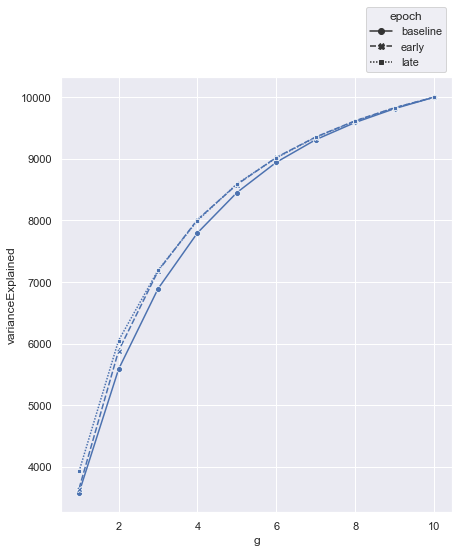

In [84]:
ax = seaborn.lineplot(x='g', y=y, data=df_var_mean.reset_index(), style='epoch', markers=True)
seaborn.move_legend(ax, "lower right", bbox_to_anchor=(1, 1))
plt.savefig("cumsum.svg", format="svg")